# COVID-19 prediction: Interpretable Trees

## Import data and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xlrd
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
import os
from julia import Julia
os.environ['IAI_DISABLE_COMPILED_MODULES'] = 'True'
jpath = "/Users/alexandreberkovic/.julia/juliaup/julia-1.8.2+0.x64/bin/julia" # path to Julia, from current directory (your path may be slightly different)
sysimg = '/Users/alexandreberkovic/.julia/juliaup/julia-1.8.2+0.x64/lib/julia/sys.dylib'
jl = Julia(runtime=jpath, sysimage = sysimg, compiled_modules=False) # compiled_modules=True may work for you; it didn't for me
jl

In [9]:
df = pd.read_csv('Data_cleaned/covid_clean_imputted_aggregated.csv')
df_std = pd.read_csv('Data_cleaned/covid_clean_imputted_std_aggregated.csv')

In [10]:
df.head()

,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,inpatient_beds_used,...,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid,all_pediatric_inpatient_bed_occupied,all_pediatric_inpatient_beds,staffed_pediatric_icu_bed_occupancy,total_staffed_pediatric_icu_beds
0,2020-03-28,0.0,0.000776,0.999999,0.0,0.000776,0.999999,3.506830,5469.783126,2927.137023,...,2.246885,2.495485,2.995639,3.082520,7.262577,6.869051,179.767629,527.565725,41.440877,76.693712
1,2020-03-29,0.0,0.000623,1.000000,0.0,0.000623,1.000000,3.972720,5584.200081,2885.303293,...,3.031170,3.563133,3.891351,3.723580,6.777545,5.528161,181.968506,535.829118,38.000574,63.991322
2,2020-03-30,0.0,0.000469,1.000000,0.0,0.000469,1.000000,3.440062,6006.318836,3081.900031,...,2.639507,3.546374,3.989166,3.208576,3.163899,9.101223,290.884006,782.611038,72.996837,171.462158
3,2020-03-31,0.0,0.000403,1.000000,0.0,0.000403,1.000000,4.773635,6156.061474,3326.144843,...,3.058241,4.009273,4.415866,3.427776,3.207501,10.683529,331.627700,724.346119,81.510714,182.581633
4,2020-04-01,0.0,0.000342,1.000000,0.0,0.000342,1.000000,8.201886,6296.550516,3299.158770,...,2.602756,3.965356,3.928165,2.776288,1.534364,14.746292,289.787095,717.664592,90.859759,205.789287


### Optimal Regression Trees

In [5]:
# replace the row number with the date
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# replace the row number with the date
df_std['date'] = pd.to_datetime(df_std['date'])
df_std = df_std.set_index('date')

In [6]:
#  sort the index by date in ascending order and then by country in descending order 
df = df.sort_index(ascending=True, axis=0)

#  sort the index by date in ascending order and then by country in descending order 
df_std = df_std.sort_index(ascending=True, axis=0)

Text(0.5, 1.0, 'Deaths due to COVID-19')

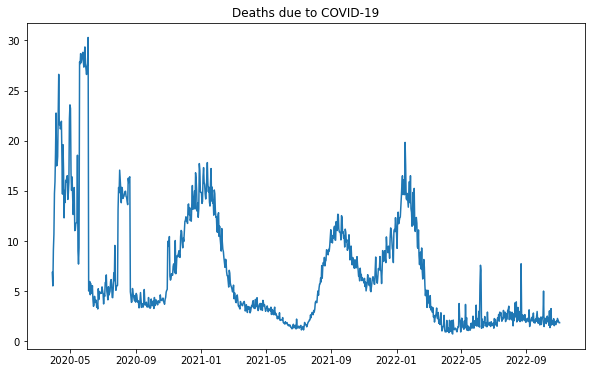

In [7]:
# plot df['deaths_covid']
plt.figure(figsize=(10, 6))
plt.plot(df['deaths_covid'])
plt.title('Deaths due to COVID-19')

In [8]:
df.head()

,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,inpatient_beds_used,inpatient_beds_used_covid,...,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid,all_pediatric_inpatient_bed_occupied,all_pediatric_inpatient_beds,staffed_pediatric_icu_bed_occupancy,total_staffed_pediatric_icu_beds
date,,,,,,,,,,,,,,,,,,,,,
2020-03-28,0.0,0.000776,0.999999,0.0,0.000776,0.999999,3.506830,5469.783126,2927.137023,520.553135,...,2.246885,2.495485,2.995639,3.082520,7.262577,6.869051,179.767629,527.565725,41.440877,76.693712
2020-03-29,0.0,0.000623,1.000000,0.0,0.000623,1.000000,3.972720,5584.200081,2885.303293,539.273885,...,3.031170,3.563133,3.891351,3.723580,6.777545,5.528161,181.968506,535.829118,38.000574,63.991322
2020-03-30,0.0,0.000469,1.000000,0.0,0.000469,1.000000,3.440062,6006.318836,3081.900031,552.949996,...,2.639507,3.546374,3.989166,3.208576,3.163899,9.101223,290.884006,782.611038,72.996837,171.462158
2020-03-31,0.0,0.000403,1.000000,0.0,0.000403,1.000000,4.773635,6156.061474,3326.144843,613.469941,...,3.058241,4.009273,4.415866,3.427776,3.207501,10.683529,331.627700,724.346119,81.510714,182.581633
2020-04-01,0.0,0.000342,1.000000,0.0,0.000342,1.000000,8.201886,6296.550516,3299.158770,607.363753,...,2.602756,3.965356,3.928165,2.776288,1.534364,14.746292,289.787095,717.664592,90.859759,205.789287
